# Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px 
sns.set_style('darkgrid')
from datetime import datetime
from dateutil.tz import *
import re 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import os


# Importing the dataset

In [2]:
#Importing the dataset
data = pd.read_csv('SolarPrediction.csv')
data.info()
df=data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data cleaning and preparation

> In this section, the dataset is analysed to identify whether there are missing values and whether all the data is identified by the correct data-type. 

In [3]:
data.isnull().sum()

UNIXTime                  0
Data                      0
Time                      0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
TimeSunRise               0
TimeSunSet                0
dtype: int64

A preliminary analysis of the dataset indicates that there are no missing values.

> The UNIXTime is converted into a datetime object, and the right timezone is allocated to this feature.

In [4]:
data = data.sort_values(['UNIXTime'], ascending = [True])
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
7416,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
7415,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
7414,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
7413,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
7412,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


> Next step is to convert time and date parameters into a more useful format and add some coloumns that may be useful for visualisation and analysis.

In [5]:
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
data.index =  pd.to_datetime(data['UNIXTime'], unit='s')
data.index = data.index.tz_localize(pytz.utc).tz_convert(hawaii)
data['MonthOfYear'] = data.index.strftime('%m').astype(int)
data['DayOfYear'] = data.index.strftime('%j').astype(int)
data['WeekOfYear'] = data.index.strftime('%U').astype(int)
data['TimeOfDay(h)'] = data.index.hour
data['TimeOfDay(m)'] = data.index.hour*60 + data.index.minute
data['TimeOfDay(s)'] = data.index.hour*60*60 + data.index.minute*60 + data.index.second
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S')
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S')
data['DayLength(s)'] = data['TimeSunSet'].dt.hour*60*60 \
                           + data['TimeSunSet'].dt.minute*60 \
                           + data['TimeSunSet'].dt.second \
                           - data['TimeSunRise'].dt.hour*60*60 \
                           - data['TimeSunRise'].dt.minute*60 \
                           - data['TimeSunRise'].dt.second
data.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
data.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
UNIXTime,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,1472724008,2.58,51,30.43,103,77.27,11.25,9,245,35,0,0,8,45060
2016-09-01 00:05:10-10:00,1472724310,2.83,51,30.43,103,153.44,9.00,9,245,35,0,5,310,45060
2016-09-01 00:20:06-10:00,1472725206,2.16,51,30.43,103,142.04,7.87,9,245,35,0,20,1206,45060
2016-09-01 00:25:05-10:00,1472725505,2.21,51,30.43,103,144.12,18.00,9,245,35,0,25,1505,45060
2016-09-01 00:30:09-10:00,1472725809,2.25,51,30.43,103,67.42,11.25,9,245,35,0,30,1809,45060


> If the data handling has been carried out correctly, then it would be reasonable to expect that the solar radiation, for any considered day, would be approximately zero before the sunrise time, and after the sunset time. 

No handles with labels found to put in legend.


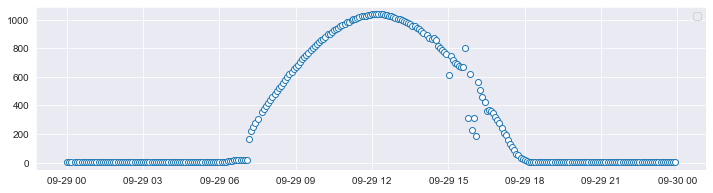

In [6]:
data_one_day = data.loc['2016-09-29':'2016-09-30',:]

plt.figure(figsize = (12,3))
plt.plot(data_one_day.Radiation, 'o', markerfacecolor = 'w')
plt.gca().xaxis_date('HST')

plt.legend()
plt.show()

The plot suggests that the various dates have been correctly manipulated. It is now possible to proceed with the preliminary data analysis of the dataset.

# Preliminary Data Analysis

> The first step of the preliminary data analysis is therefore to check the ranges of the various features of the dataset, and to do a cross-check whether these ranges are reasonable.

In [7]:
#Analysing the ranges of the various features of the datset
data.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,MonthOfYear,DayOfYear,WeekOfYear,TimeOfDay(h),TimeOfDay(m),TimeOfDay(s),DayLength(s)
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,10.526066,306.110965,43.871015,11.557425,721.002203,43277.574068,41433.032491
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,1.096691,34.781367,4.963061,6.912034,415.011513,24900.749819,1795.873502
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,9.000000,245.000000,35.000000,0.000000,0.000000,1.000000,39360.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,10.000000,277.000000,40.000000,6.000000,360.000000,21617.000000,39720.000000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,11.000000,306.000000,44.000000,12.000000,720.000000,43230.000000,41040.000000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,11.000000,334.000000,48.000000,18.000000,1080.000000,64849.000000,42900.000000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,12.000000,366.000000,52.000000,23.000000,1436.000000,86185.000000,45060.000000


The ranges here identified look reasonable. In particular:

* The Solar radiation assumes only positive values, and has a maximum value of 1600 W/m^2 
* The temperature ranges from 30.4 F to 71 F
* The pressure variates very little, and in any case has a value of around 1 bar
* The Humidity has values over 100 %, but only very slightly
* Wind direction is correctly in the range from 0 to 360 degrees
* Wind speed is always positive, and its maximum value is reasonable as it corresponds to a grade 8 of the Beaufort scale

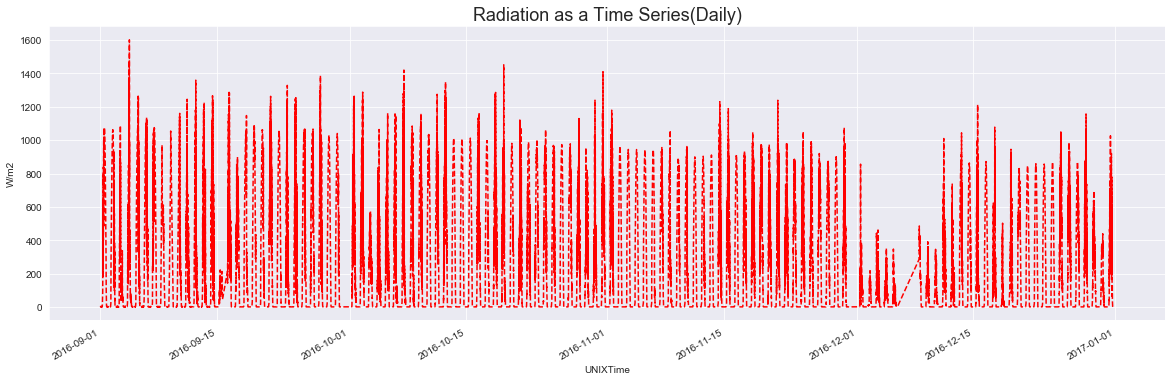

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
data['Radiation'].plot(ax=ax, style=['--'], color='red')
ax.set_title('Radiation as a Time Series(Daily)', fontsize=18)
ax.set_ylabel('W/m2')
plt.show()

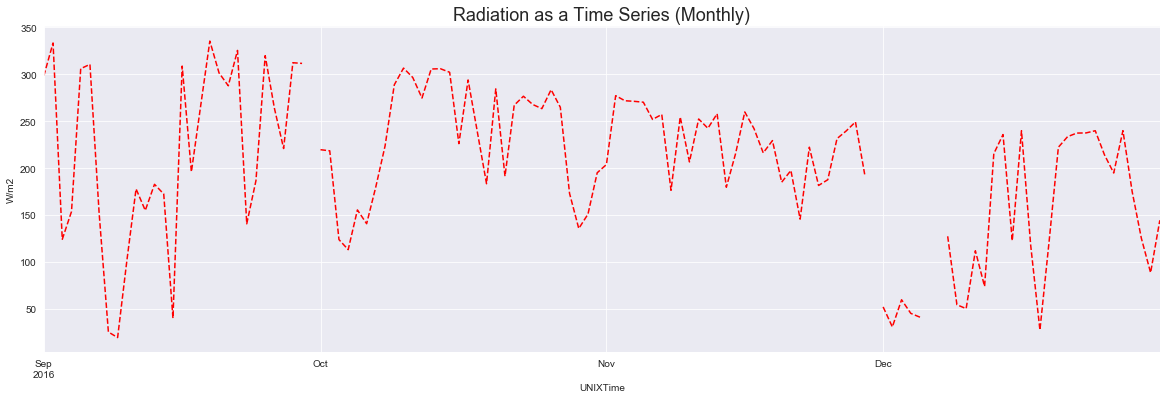

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
data.groupby(pd.Grouper(freq="D"))['Radiation'].mean().plot(ax=ax, style=['--'], color='red')
ax.set_title('Radiation as a Time Series (Monthly)', fontsize=18)
ax.set_ylabel('W/m2')
plt.show()

> Next step is to check for the distribution of the data, in order to understand how the various data is allocated between the lower and upper limits. This can be carried out by plotting either a distribution plot or a boxplot.

> Both are plotted in this case, as they enable to have a more comprehensive understanding of the data.

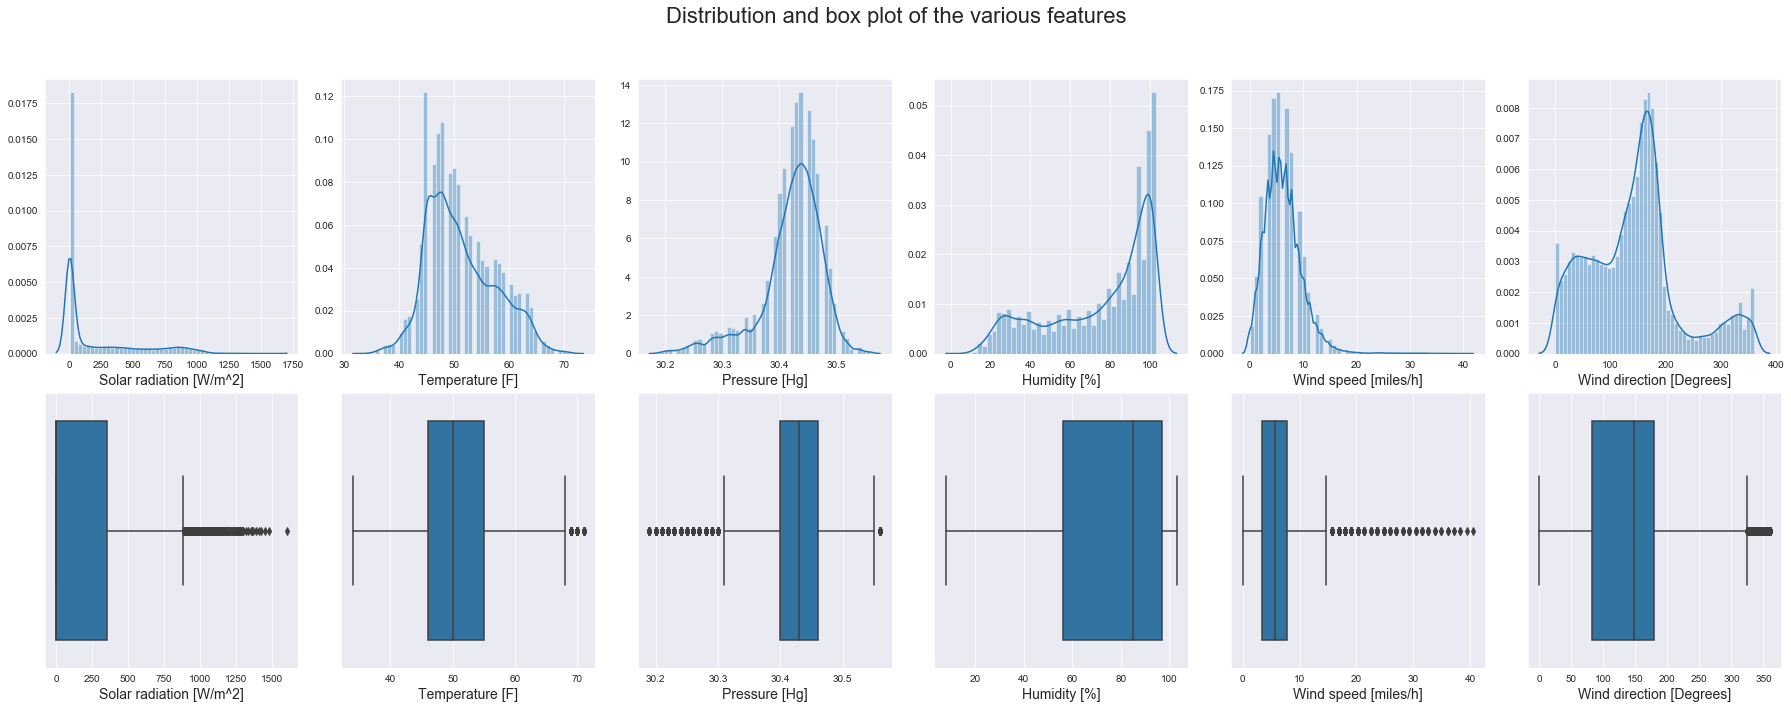

In [10]:
fig, ax = plt.subplots(nrows =2, ncols = 6, figsize = (25, 10))

sns.distplot(data.Radiation, ax = ax[0,0])
ax[0,0].set_xlabel('Solar radiation [W/m^2]', fontsize = 14)

sns.distplot(data.Temperature, ax = ax[0,1])
ax[0,1].set_xlabel('Temperature [F]', fontsize = 14)

sns.distplot(data.Pressure, ax = ax[0,2])
ax[0,2].set_xlabel('Pressure [Hg]', fontsize = 14)

sns.distplot(data.Humidity, ax = ax[0,3])
ax[0,3].set_xlabel('Humidity [%]', fontsize = 14)

sns.distplot(data.Speed, ax = ax[0,4])
ax[0,4].set_xlabel('Wind speed [miles/h]', fontsize = 14)

sns.distplot(data['WindDirection(Degrees)'], ax = ax[0,5])
ax[0,5].set_xlabel('Wind direction [Degrees]', fontsize = 14)


sns.boxplot(data.Radiation, ax = ax[1,0])
ax[1,0].set_xlabel('Solar radiation [W/m^2]', fontsize = 14)

sns.boxplot(data.Temperature, ax = ax[1,1])
ax[1,1].set_xlabel('Temperature [F]', fontsize = 14)

sns.boxplot(data.Pressure, ax = ax[1,2])
ax[1,2].set_xlabel('Pressure [Hg]', fontsize = 14)

sns.boxplot(data.Humidity, ax = ax[1,3])
ax[1,3].set_xlabel('Humidity [%]', fontsize = 14)

sns.boxplot(data.Speed, ax = ax[1,4])
ax[1,4].set_xlabel('Wind speed [miles/h]', fontsize = 14)

sns.boxplot(data['WindDirection(Degrees)'], ax = ax[1,5])
ax[1,5].set_xlabel('Wind direction [Degrees]', fontsize = 14)

fig.suptitle('Distribution and box plot of the various features', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

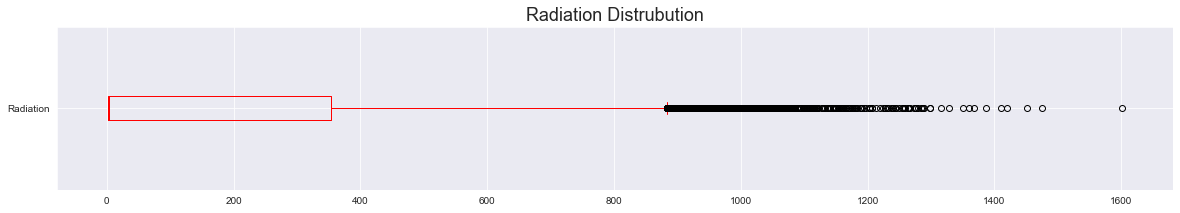

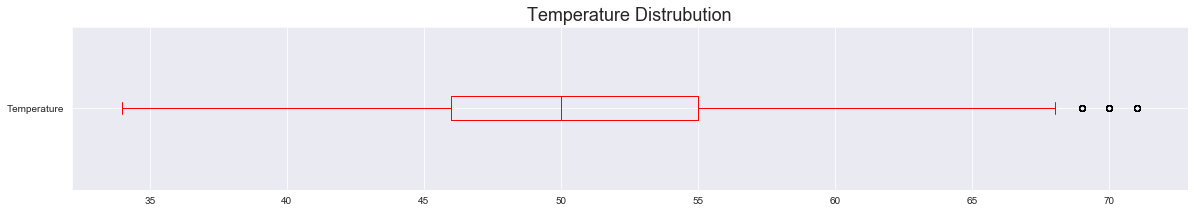

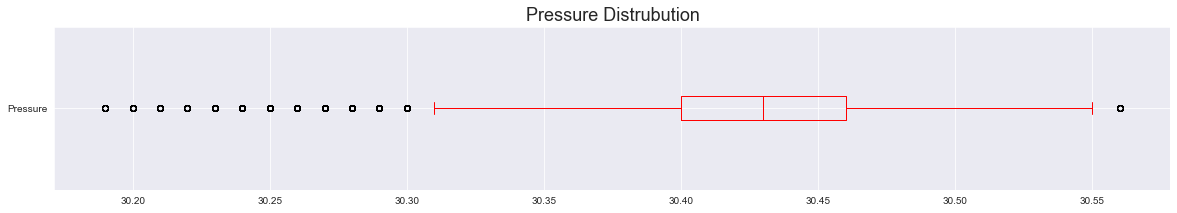

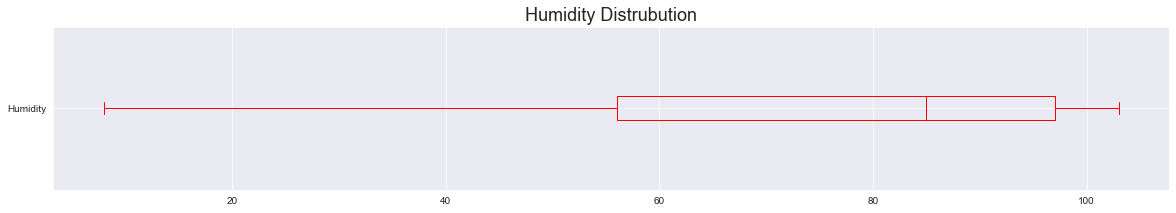

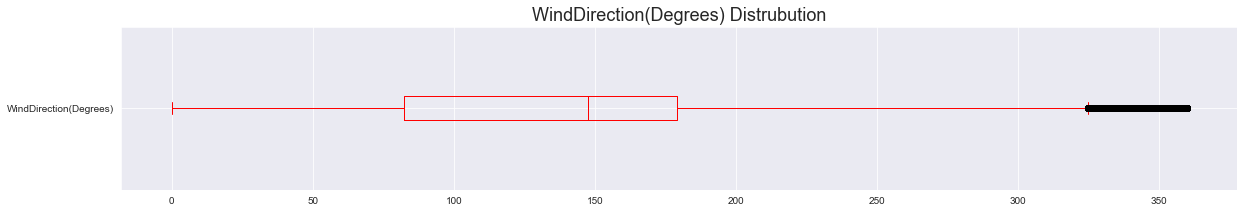

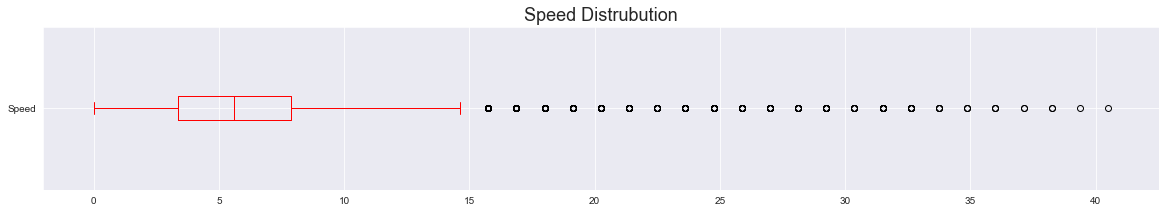

In [11]:
for col in ['Radiation','Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed']:
    fig, ax = plt.subplots(figsize=(20, 3))
    data[col].plot.box(ax=ax, vert=False, color='red')
    ax.set_title(f'{col} Distrubution', fontsize=18)
    plt.show()

Looking at the distribution of the data it is possible to conclude that most features have a skewed distribution, except for the wind directions, which is characterized by three peaks.

As it was possible to assume, roughtly 50 % of values of the solar radiation are located in the range between 0 W/^2 and 250 W/m^2 (there is no or little solar radiation at night). With respect to the wind speed, it seems that the high wind speeds areextreme outliers in a distribution that has most of its values in the range between 0 miles/h and 20 miles/h.

> As a last step in the preliminary data analysis, it makes good sense to plot the data for limited range of time. In this case, a five-day period is selected.

> Aside from the data, also the hourly-median of the data is represented in the following plots. This allows for an easier identification of potential patterns. The median is selected over the mean, because it is less affected by the presence of potential outliers.

In [12]:
#Creation of the median dataset
data_median = data.resample('H').median().dropna()

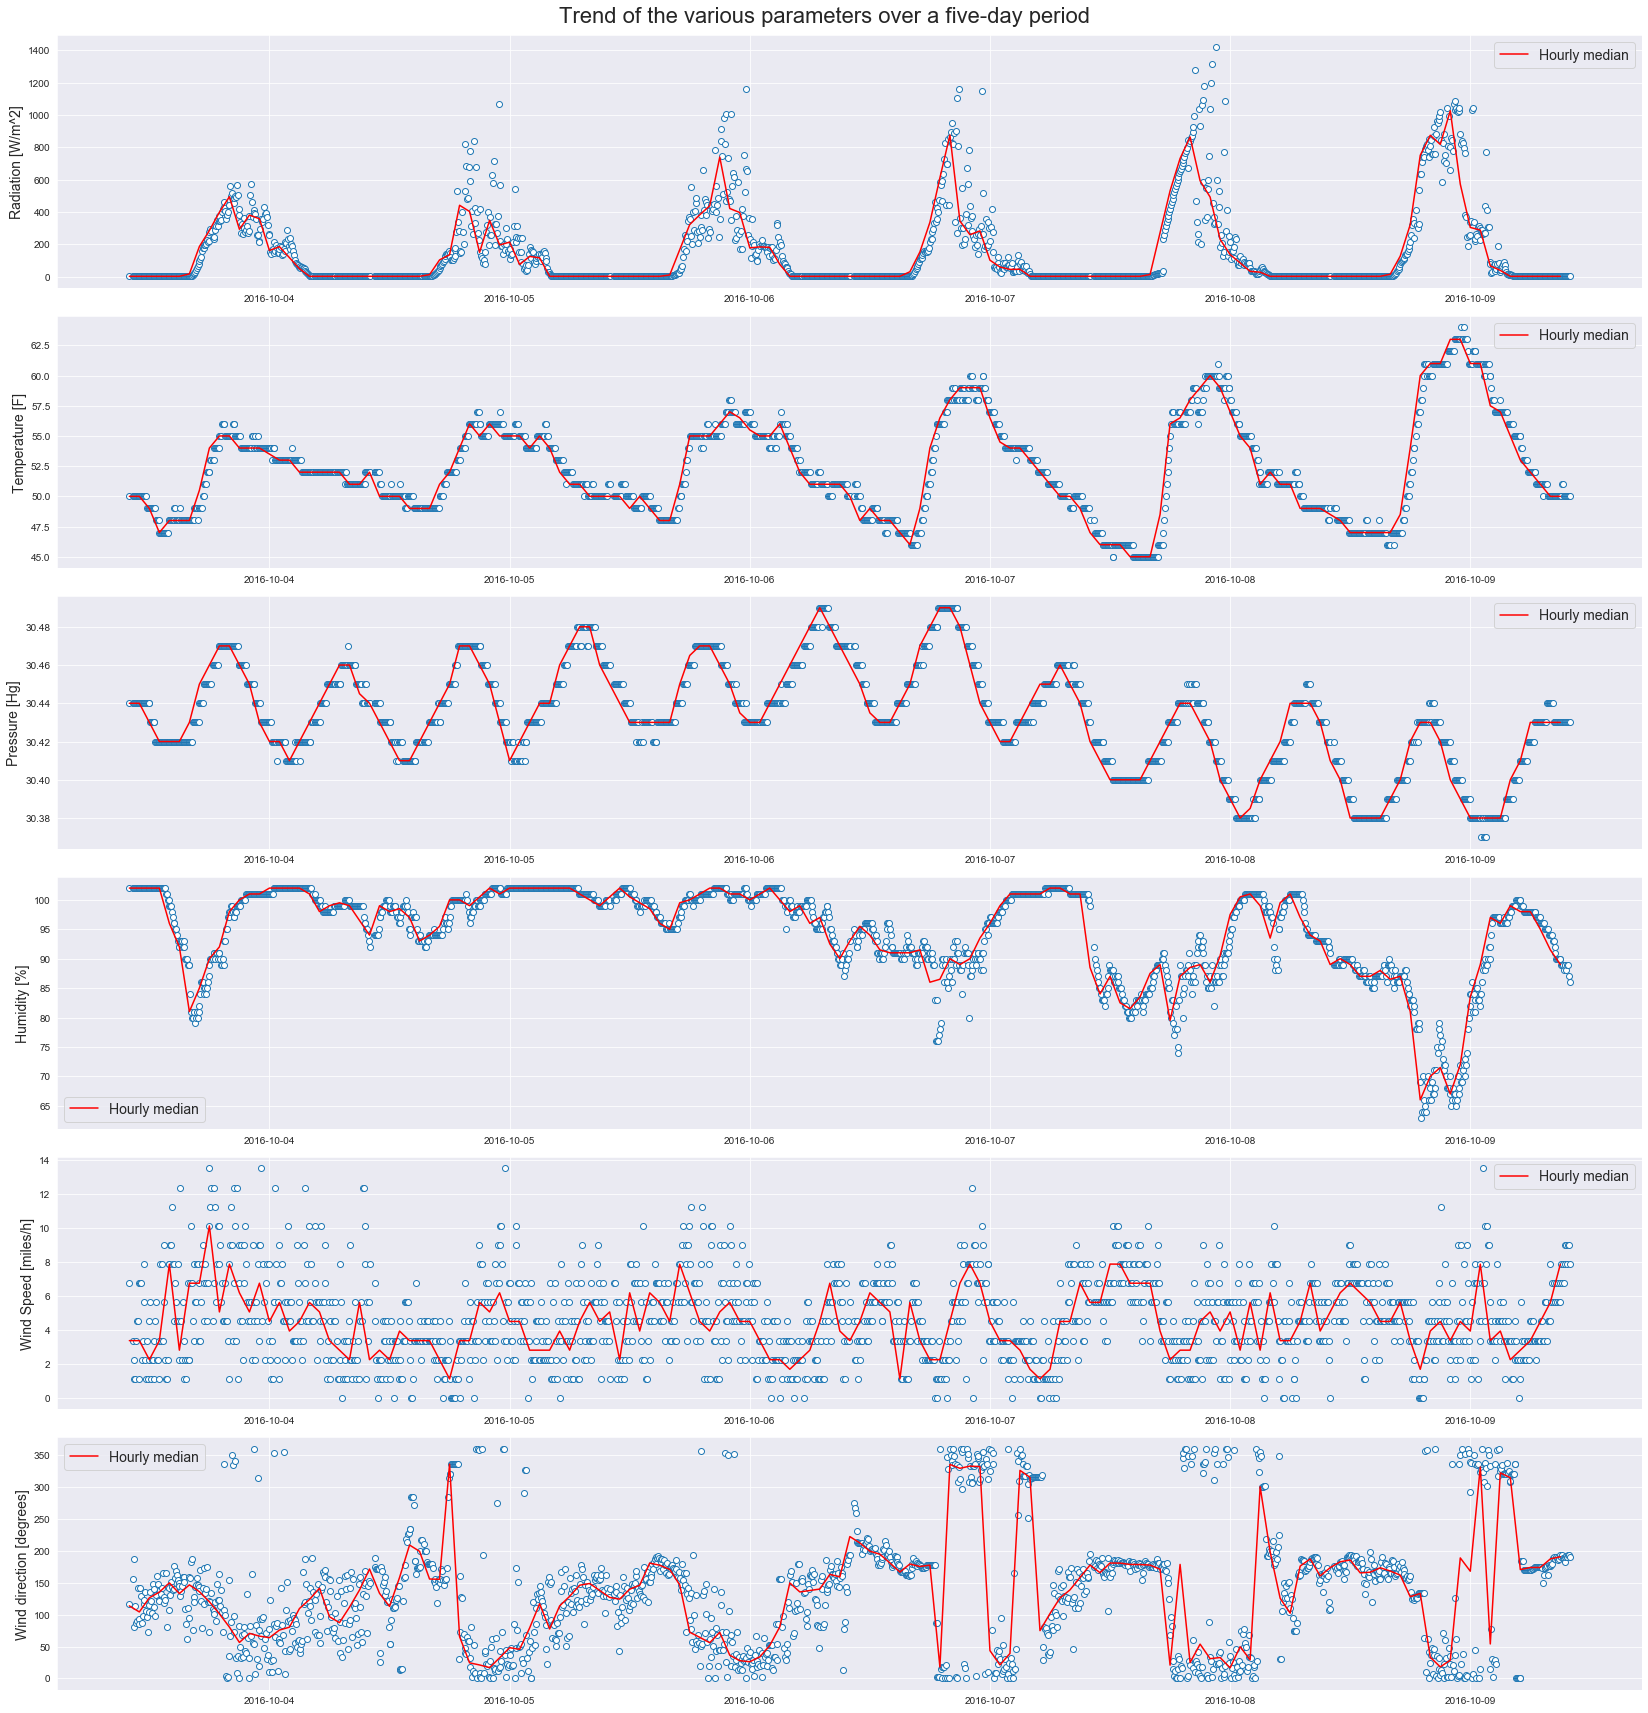

In [13]:
#Extraction of the data for a five-day period
data_5 = data.loc['2016-10-03':'2016-10-08',:]
data_5_median = data_median.loc['2016-10-03':'2016-10-08',:]


fig, ax = plt.subplots(nrows =6, ncols = 1, figsize = (23,25))

ax[0].plot(data_5.Radiation,'o', markerfacecolor='w')
ax[0].plot(data_5_median.Radiation, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[0].set_ylabel('Radiation [W/m^2]', fontsize = 14)
ax[0].legend(fontsize = 14)

ax[1].plot(data_5.Temperature,'o', markerfacecolor='w')
ax[1].plot(data_5_median.Temperature, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[1].set_ylabel('Temperature [F]', fontsize = 14)
ax[1].legend(fontsize = 14)

ax[2].plot(data_5.Pressure,'o', markerfacecolor='w')
ax[2].plot(data_5_median.Pressure, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[2].set_ylabel('Pressure [Hg]', fontsize = 14)
ax[2].legend(fontsize = 14)

ax[3].plot(data_5.Humidity,'o', markerfacecolor='w')
ax[3].plot(data_5_median.Humidity, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[3].set_ylabel('Humidity [%]', fontsize = 14)
ax[3].legend(fontsize = 14)

ax[4].plot(data_5.Speed,'o', markerfacecolor='w')
ax[4].plot(data_5_median.Speed, linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[4].set_ylabel('Wind Speed [miles/h]', fontsize = 14)
ax[4].legend(fontsize = 14)

ax[5].plot(data_5['WindDirection(Degrees)'],'o', markerfacecolor='w')
ax[5].plot(data_5_median['WindDirection(Degrees)'], linewidth = 1.5, color = 'red', label = 'Hourly median')
ax[5].set_ylabel('Wind direction [degrees]', fontsize = 14)
ax[5].legend(fontsize = 14)

fig.suptitle('Trend of the various parameters over a five-day period', fontsize = 22)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])

plt.show()

Looking at the plots it is possible to deduce the following:

1. The data for the Temperature, humidity, and wind speed seems to assume only discrete values. This could be connected with the type of sensors used for the data campaing;
2. The pressure data seems to follow some clear pattern in which high and low pressure values interchange each other;
3. The wind speed data is extremely volatile. The high volatility could make this feature a less "certain" one when carrying out the regression analysis;
4. As expected, solar radiation is constant at zero during the night, but high variability is experienced during the day-hours;
5. The wind direction data is volatile, but clear trends can be identified. Sometimes the variation of the measurements between 0 degrees and 360 degrees create a sense of "change" of the wind direction, which in practice is not there.

> In order to get a better understanding of the data, hourly and monthly means of several variables were visualised using bar plots.

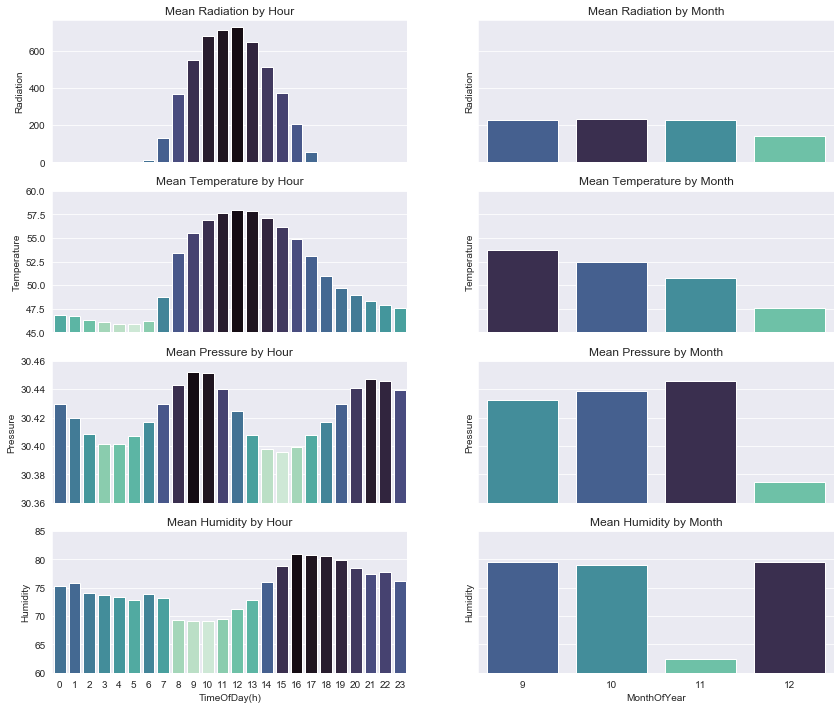

In [14]:
grouped_m=data.groupby('MonthOfYear').mean().reset_index()
grouped_w=data.groupby('WeekOfYear').mean().reset_index()
grouped_d=data.groupby('DayOfYear').mean().reset_index()
grouped_h=data.groupby('TimeOfDay(h)').mean().reset_index()

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(14,12))
ax3.set_ylim(45,60)
ax5.set_ylim(30.36,30.46)
ax7.set_ylim(60,85)

ax1.set_title('Mean Radiation by Hour')
pal = sns.color_palette("mako", len(grouped_h))
rank = grouped_h['Radiation'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Radiation', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
pal = sns.color_palette("mako", len(grouped_m))
rank = grouped_m['Radiation'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Radiation', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax2)
ax2.set_xlabel('')

ax3.set_title('Mean Temperature by Hour')
pal = sns.color_palette("mako", len(grouped_h))
rank = grouped_h['Temperature'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Temperature', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax3)
ax3.set_xlabel('')

ax4.set_title('Mean Temperature by Month')
pal = sns.color_palette("mako", len(grouped_m))
rank = grouped_m['Temperature'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Temperature', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax4)
ax4.set_xlabel('')

ax5.set_title('Mean Pressure by Hour')
pal = sns.color_palette("mako", len(grouped_h))
rank = grouped_h['Pressure'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Pressure', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax5)
ax5.set_xlabel('')

ax6.set_title('Mean Pressure by Month')
pal = sns.color_palette("mako", len(grouped_m))
rank = grouped_m['Pressure'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Pressure', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax6)
ax6.set_xlabel('')

ax7.set_title('Mean Humidity by Hour')
pal = sns.color_palette("mako", len(grouped_h))
rank = grouped_h['Humidity'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Humidity', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax7)

ax8.set_title('Mean Humidity by Month')
pal = sns.color_palette("mako", len(grouped_m))
rank = grouped_m['Humidity'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Humidity', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax8)

plt.show()

From the above plots, its clear that:
* Temperature has strong corellation with solar irradiance. 
* Humidity has a negative correlation with solar irradiance, temperature and pressure.
* Solar irradiance and temperature both peak at approximately 12:00. 

Additionally, monthly means of both solar irradiance and temperature appear to decrease as winter approaches, with the exception of a very slight increase in solar irradiance from September to October.



# Feature engineering and correlation analysis

> it is time to carry out correlation analyses aimed at identifying if there are clear patterns (linear or non-linear) between the variable to be predicted (the solar radiation), and the features.

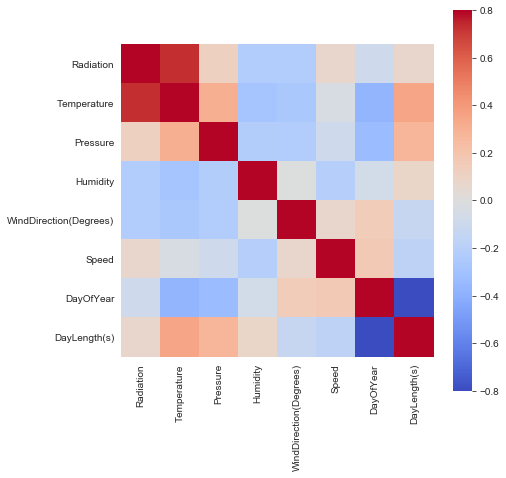

In [15]:
corrmat = data.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'UNIXTime', 'MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
corrmat = corrmat.corr()
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()

> The correlation matrix indicates a positive linear correlation between the ambient temperature and the solar radiation. No clear linear correlation appears for the other features, and the second highest correlation value is identified for the humidity.

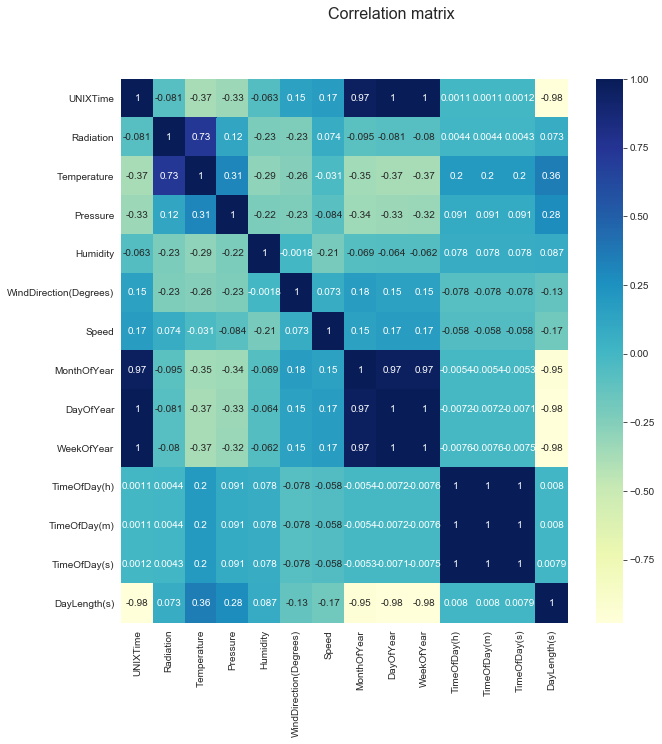

In [16]:
#Plotting a heatmap of the various features in the dataset
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(), annot = True, cmap = 'YlGnBu')
fig.suptitle('Correlation matrix', fontsize = 16)
plt.show()

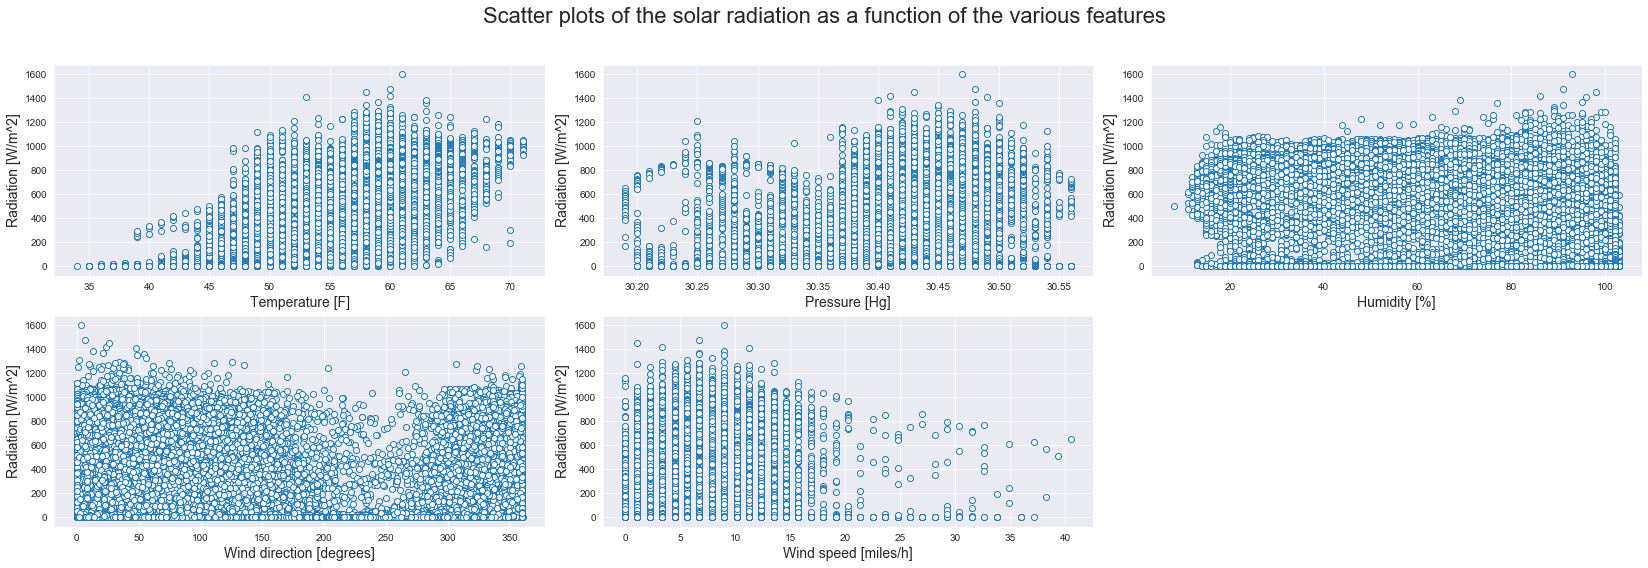

In [17]:
fig, ax = plt.subplots(nrows =2, ncols = 3, figsize = (23,8))

ax[0,0].plot(data.Temperature, data.Radiation,'o', markerfacecolor='w')
ax[0,0].set_xlabel('Temperature [F]', fontsize = 14)
ax[0,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,1].plot(data.Pressure, data.Radiation,'o', markerfacecolor='w')
ax[0,1].set_xlabel('Pressure [Hg]', fontsize = 14)
ax[0,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[0,2].plot(data.Humidity, data.Radiation,'o', markerfacecolor='w')
ax[0,2].set_xlabel('Humidity [%]', fontsize = 14)
ax[0,2].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,1].plot(data.Speed, data.Radiation,'o', markerfacecolor='w')
ax[1,1].set_xlabel('Wind speed [miles/h]', fontsize = 14)
ax[1,1].set_ylabel('Radiation [W/m^2]', fontsize = 14)

ax[1,0].plot(data['WindDirection(Degrees)'], data.Radiation,'o', markerfacecolor='w')
ax[1,0].set_xlabel('Wind direction [degrees]', fontsize = 14)
ax[1,0].set_ylabel('Radiation [W/m^2]', fontsize = 14)

fig.delaxes(ax[1,2])

fig.suptitle('Scatter plots of the solar radiation as a function of the various features', fontsize = 22)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

> The scatter plots show the distribution of the values of the various features as a function of the solar radiation. This allows to identify potential non-linear trends present.
> 
> The scatter plots suggest the following:
> 
> * It is confirmed a linear correlation between solar radiation and ambient temperature;
> * It seems that the highest values of the solar radiation are taking place when the ambient pressure is the highest;
> * It seems that the maximum present solar radiation decreases for high wind speeds.
> 

In [18]:
df['Month'] = df['Data'].apply(lambda y: re.search(r'^\d+', y).group(0))
df['Day'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\/)', y).group(0))
df['Year'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\s)', y).group(0))

In [19]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016


In [20]:
df['Month'] = df['Data'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['Day'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\/)', y).group(0)).astype(np.int)
df['Year'] = df['Data'].apply(lambda y: re.search(r'(?<=\/)\d+(?=\s)', y).group(0)).astype(np.int)

In [21]:
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016


In [22]:
df=df.drop(['Data'],axis=1)

In [23]:
df

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year
0,1475229326,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016
1,1475229023,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016
2,1475228726,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016
3,1475228421,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016
4,1475228124,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016
32682,1480587301,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016
32683,1480587001,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016
32684,1480586702,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016


In [24]:
df['Hour'] = df['Time'].apply(lambda y: re.search(r'^\d+', y).group(0))
df['Minute'] = df['Time'].apply(lambda y: re.search(r'(?<=\:)\d+(?=\:)', y).group(0))
df['Second'] = df['Time'].apply(lambda y: re.search(r'\d+$', y).group(0))

In [25]:
df

,UNIXTime,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year,Hour,Minute,Second
0,1475229326,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016,23,55,26
1,1475229023,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016,23,50,23
2,1475228726,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016,23,45,26
3,1475228421,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016,23,40,21
4,1475228124,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016,00,20,04
32682,1480587301,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016,00,15,01
32683,1480587001,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016,00,10,01
32684,1480586702,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016,00,05,02


In [26]:
df['Hour'] = df['Time'].apply(lambda y: re.search(r'^\d+', y).group(0)).astype(np.int)
df['Minute'] = df['Time'].apply(lambda y: re.search(r'(?<=\:)\d+(?=\:)', y).group(0)).astype(np.int)
df['Second'] = df['Time'].apply(lambda y: re.search(r'\d+$', y).group(0)).astype(np.int)

In [27]:
del df['Time']

In [28]:
df

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Year,Hour,Minute,Second
0,1475229326,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,2016,23,55,26
1,1475229023,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,2016,23,50,23
2,1475228726,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,2016,23,45,26
3,1475228421,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,2016,23,40,21
4,1475228124,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,2016,23,35,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,2016,0,20,4
32682,1480587301,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,2016,0,15,1
32683,1480587001,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,2016,0,10,1
32684,1480586702,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,2016,0,5,2


In [29]:
df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)', x).group(0)).astype(np.int)

df = df.drop(['TimeSunRise', 'TimeSunSet'], axis=1)

In [30]:
df

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,6,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,6,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,6,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,6,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,1.22,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,6,41,17,42
32682,1480587301,1.17,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,6,41,17,42
32683,1480587001,1.20,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,6,41,17,42
32684,1480586702,1.23,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,6,41,17,42


In [31]:
df.dtypes

UNIXTime                    int64
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Month                       int32
Day                         int32
Year                        int32
Hour                        int32
Minute                      int32
Second                      int32
SunriseHour                 int32
SunriseMinute               int32
SunsetHour                  int32
SunsetMinute                int32
dtype: object

In [32]:
y = df['Radiation'].copy()
X = df.drop('Radiation', axis=1).copy()

In [33]:
X

,UNIXTime,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
0,1475229326,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,6,13,18,13
1,1475229023,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,6,13,18,13
2,1475228726,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,6,13,18,13
3,1475228421,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,6,13,18,13
4,1475228124,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,6,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,6,41,17,42
32682,1480587301,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,6,41,17,42
32683,1480587001,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,6,41,17,42
32684,1480586702,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,6,41,17,42


In [34]:
scaler = StandardScaler()

Z = scaler.fit_transform(X)

In [35]:
pd.DataFrame(Z)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.937753,-0.500439,0.678974,-0.616253,0.407620,-0.178738,-1.391540,1.512248,0.0,1.655482,1.589236,0.660811,0.0,-0.943425,1.369126,-1.525765
1,-0.937854,-0.500439,0.678974,-0.654730,0.400285,-0.823359,-1.391540,1.512248,0.0,1.655482,1.299687,0.429167,0.0,-0.943425,1.369126,-1.525765
2,-0.937953,-0.500439,0.678974,-0.693206,0.183490,-0.823359,-1.391540,1.512248,0.0,1.655482,1.010138,0.660811,0.0,-0.943425,1.369126,-1.525765
3,-0.938054,-0.500439,0.678974,-0.577776,-0.069497,-0.823359,-1.391540,1.512248,0.0,1.655482,0.720589,0.274737,0.0,-0.943425,1.369126,-1.525765
4,-0.938153,-0.500439,0.678974,-0.500823,-0.463407,-0.178738,-1.391540,1.512248,0.0,1.655482,0.431040,0.506381,0.0,-0.943425,1.369126,-1.525765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,0.845373,-1.145490,0.130250,1.038241,0.023209,0.145006,1.344003,-1.701824,0.0,-1.672098,-0.437606,-1.037912,0.0,0.860876,-0.730393,0.293766
32682,0.845273,-1.145490,-0.052658,1.038241,-0.309138,0.145006,1.344003,-1.701824,0.0,-1.672098,-0.727155,-1.269556,0.0,0.860876,-0.730393,0.293766
32683,0.845173,-1.145490,-0.052658,1.038241,0.020443,0.789627,1.344003,-1.701824,0.0,-1.672098,-1.016704,-1.269556,0.0,0.860876,-0.730393,0.293766
32684,0.845073,-1.145490,-0.052658,0.999764,0.248901,0.465884,1.344003,-1.701824,0.0,-1.672098,-1.306253,-1.192341,0.0,0.860876,-0.730393,0.293766


In [36]:
df['Year'].unique()

array([2016])

In [37]:
df.drop(['SunriseHour'],axis=1)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseMinute,SunsetHour,SunsetMinute
0,1475229326,1.21,48,30.46,59,177.39,5.62,9,29,2016,23,55,26,13,18,13
1,1475229023,1.21,48,30.46,58,176.78,3.37,9,29,2016,23,50,23,13,18,13
2,1475228726,1.23,48,30.46,57,158.75,3.37,9,29,2016,23,45,26,13,18,13
3,1475228421,1.21,48,30.46,60,137.71,3.37,9,29,2016,23,40,21,13,18,13
4,1475228124,1.17,48,30.46,62,104.95,5.62,9,29,2016,23,35,24,13,18,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,1.22,44,30.43,102,145.42,6.75,12,1,2016,0,20,4,41,17,42
32682,1480587301,1.17,44,30.42,102,117.78,6.75,12,1,2016,0,15,1,41,17,42
32683,1480587001,1.20,44,30.42,102,145.19,9.00,12,1,2016,0,10,1,41,17,42
32684,1480586702,1.23,44,30.42,101,164.19,7.87,12,1,2016,0,5,2,41,17,42


# Modeling 

# Data Training

In [38]:
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
kf = KFold(shuffle=True, random_state=19)

In [39]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

trees = {
    'linear': LinearRegression(),
    'randomfor': RandomForestRegressor(random_state=19), 
    'gradientb': GradientBoostingRegressor(random_state=19), 
    'DecisionTr': DecisionTreeRegressor(random_state=19),
}

In [40]:
scores = []
rmse=[]
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Linear regression

In [41]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regresor_pred = regression_model.predict(X_test)
scores.append(100*regression_model.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, regression_model.predict(X_test))))

# Random forest Regression

In [42]:
Randomforest= RandomForestRegressor(random_state=7).fit(X_train, y_train)
scores.append(100*Randomforest.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, Randomforest.predict(X_test))))

# Gradient boosting Regression

In [43]:
Gradientboost = GradientBoostingRegressor(random_state=19).fit(X_train, y_train)
scores.append(100*Gradientboost.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, Gradientboost.predict(X_test))))

# Decision Tree

In [44]:
DecisionTr = DecisionTreeRegressor(random_state=19).fit(X_train, y_train)
scores.append(100*DecisionTr.score(X_test, y_test))
rmse.append(np.sqrt(mean_squared_error(y_test, DecisionTr.predict(X_test))))

# RMSE scores

In [45]:
rmse,scores

([190.80223807681944, 77.362121487893, 106.78460583378411, 103.53905920738883],
 [63.35711676957613, 93.97607645687597, 88.52269276818731, 89.20975915661509])

# Testing data : R-squared & rmse

In [46]:
test1=pd.DataFrame({"model":['Linear Regression', 'Random Forest','Gradient Boosting','Decision Tree'],
                   "r2":[scores[0],scores[1],scores[2],scores[3]],
                   "rmse":[rmse[0],rmse[1],rmse[2],rmse[3]]
                   })
test1

,model,r2,rmse
0,Linear Regression,63.357117,190.802238
1,Random Forest,93.976076,77.362121
2,Gradient Boosting,88.522693,106.784606
3,Decision Tree,89.209759,103.539059


In [48]:
import plotly.graph_objects as go
fig = go.Figure(data=[
                      go.Bar(x=test1.model,y=test1.rmse),
                      go.Bar(x=test1.model,y=test1.r2),
])
fig.show()